In [1]:
from utils import session_ctrl
from subprocess import Popen, PIPE
from time import sleep, time
import pandas as pd
from IPython.display import display, HTML
from pathlib import Path

In [2]:
# local path to build game
build_folder = Path(R'D:\other\Build\lyra\Develop')

In [106]:
#start the game
# this can be replaced with python-jenkins to run on external computer
p = Popen([
    build_folder.joinpath('LyraGame.exe'),
    "-Messaging",
    '-execcmds=stat unitgraph, r.vsync 0, t.FPSChart.DoCsvProfile 1, t.FPSChart.OpenFolderOnDump 0, r.ProfileGPU.Sort 1, open /ShooterMaps/Maps/L_Expanse?Name=Player?listen?Experience=B_ShooterGame_Elimination']
)

In [4]:
# Expects Unreal Engine open in background with Remote Execution
saved_folder = str(build_folder.joinpath('LyraStarterGame', 'Saved').resolve())
log_path =str(build_folder.joinpath('LyraStarterGame', 'Saved', 'Logs', 'LyraStarterGame.log').resolve())
session = session_ctrl.UnrealEngineConnection(saved_folder, log_path)

searching for connection...
Connected


## What is the cost of running with lumen?

We know that Lumen is cpu bound.

We can check costs with `r.Lumen.DiffuseIndirect.Allow 0` and compare difference between profilegpu frames

In [7]:
# teleport to location
_ = session.rc('BugItGo -2892.954466 -336.022674 -117.850910 -1.960022 345.580200 0.000000')

In [8]:
profilegpu_df = session.run_profile_gpu('location1_', read_for=3000)

In [9]:
_ = session.rc('r.Lumen.DiffuseIndirect.Allow 0')

In [10]:
profilegpu_df_no_lumen = session.run_profile_gpu('location1_no_lumen', read_for=3000)

In [12]:
session_ctrl.compare_profilegpu_df(profilegpu_df, profilegpu_df_no_lumen).head(20)

,count_x,max_x,sum_x,max_position_x,count_y,max_y,sum_y,max_position_y,exists in df,diff
name,,,,,,,,,,
Scene,1.0,28.05,28.05,[1],1.0,20.3,20.3,[1],both,7.75
FRAME,1.0,28.78,28.78,[0],1.0,21.14,21.14,[0],both,7.64
DiffuseIndirectAndAO,1.0,7.7,7.7,[2],1.0,0.09,0.09,[379],both,7.61
LumenScreenProbeGather,1.0,4.47,4.47,[3],0,0,0,0,left_only,4.47
LumenSceneLighting,1.0,2.97,2.97,[134],0,0,0,0,left_only,2.97
LumenReflections,1.0,2.92,2.92,[69],0,0,0,0,left_only,2.92
LightCompositionTasks_PreLighting,1.0,0.01,0.01,[698],1.0,1.22,1.22,[240],both,-1.21
AmbientOcclusionPS,0,0,0,0,2.0,0.76,1.12,"[241, 242]",right_only,-1.12
RadianceCache,2.0,0.68,0.96,"[10, 207]",0,0,0,0,left_only,0.96


# Start FPS Chart stress testing

If a game have some useful functions for stress test it with short records of fpschart

In [15]:
result = []
session.rc('open /ShooterMaps/Maps/L_Expanse?Name=Player?listen?Experience=B_ShooterGame_Elimination')
sleep(3)
for i in range(20):
    sleep(0.5)
    session.rc('AddPlayerBot')
    df, med_df, med = session.do_fps_chart(3, f'stress_lyra_{i}')
    # save median  
    result.append(med_df)

In [103]:
# joins result to a table
result_med = result[0].join(result[1:]).T
display(result_med)

,FrameTime,GPUTime,RenderThreadTime,GameThreadTime,RHIThreadTime,RHI/DrawCalls,RHI/PrimitivesDrawn
stress_lyra_0,21.67570,21.14900,8.06300,4.87470,19.27910,497.0,609069.0
stress_lyra_1,23.74590,23.55450,13.77320,9.54220,19.94370,517.0,795704.0
stress_lyra_2,24.32910,24.04140,13.58390,9.76370,20.54430,557.0,894024.0
stress_lyra_3,23.87600,23.61140,13.48730,10.93770,20.44060,589.5,1017859.0
stress_lyra_4,24.25170,23.79080,12.80705,11.80210,22.16100,604.0,971409.0
stress_lyra_5,24.82275,24.63950,10.30420,8.80015,21.53230,618.0,1178763.0
stress_lyra_6,25.36605,25.45915,12.81715,12.46975,21.20195,677.0,1558568.0
stress_lyra_7,25.32640,25.17370,15.11170,15.78160,22.93020,752.0,1393164.0
stress_lyra_8,27.05400,26.98380,18.08555,18.72705,24.35960,771.0,2099769.0
stress_lyra_9,26.12660,25.98500,15.96680,18.59170,23.52400,761.0,1853614.0


In [104]:
# makes index a number of additional bots
result_med.index = result_med.index.str.split('_', expand=True).get_level_values(2)
result_med.index = result_med.index.to_series().astype(int)+1
display(result_med)

,FrameTime,GPUTime,RenderThreadTime,GameThreadTime,RHIThreadTime,RHI/DrawCalls,RHI/PrimitivesDrawn
1,21.67570,21.14900,8.06300,4.87470,19.27910,497.0,609069.0
2,23.74590,23.55450,13.77320,9.54220,19.94370,517.0,795704.0
3,24.32910,24.04140,13.58390,9.76370,20.54430,557.0,894024.0
4,23.87600,23.61140,13.48730,10.93770,20.44060,589.5,1017859.0
5,24.25170,23.79080,12.80705,11.80210,22.16100,604.0,971409.0
6,24.82275,24.63950,10.30420,8.80015,21.53230,618.0,1178763.0
7,25.36605,25.45915,12.81715,12.46975,21.20195,677.0,1558568.0
8,25.32640,25.17370,15.11170,15.78160,22.93020,752.0,1393164.0
9,27.05400,26.98380,18.08555,18.72705,24.35960,771.0,2099769.0
10,26.12660,25.98500,15.96680,18.59170,23.52400,761.0,1853614.0


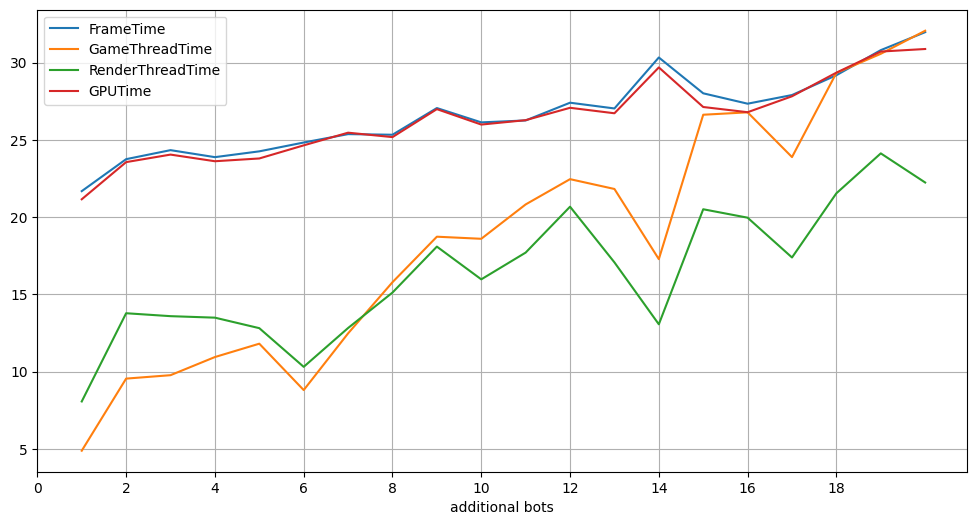

In [105]:
plt = result_med[['FrameTime', 'GameThreadTime', 'RenderThreadTime', 'GPUTime']].plot(figsize=(12,6), xticks=range(0, 20, 2), xlabel='additional bots', grid=True)

# Stat fps for spread of the frames
Enhanced input allows to control your character

For example this can help to do some quick profiling for vfx

In [ ]:
session.rc('open /ShooterMaps/Maps/L_Expanse?Name=Player?listen?Experience=B_ShooterGame_Elimination')
sleep(3)

# make player character shoots every 0.1 seconds
session.rc('startfpschart')
sleep(0.5)
for i in range(10):
    session.rc('input.+key leftmousebutton')
    session.rc('input.-key leftmousebutton')
    sleep(0.1)
shoots, shots_interesting_stats_med, shots_med = session.stop_fps_chart('shots')

In [113]:
display(round(shoots[['FrameTime', 'GameThreadTime', 'RenderThreadTime', 'GPUTime']].describe(), 2))

,FrameTime,GameThreadTime,RenderThreadTime,GPUTime
count,336.00,336.00,336.00,336.00
mean,21.75,4.52,10.15,21.68
std,1.27,0.57,1.29,0.83
min,17.96,3.58,8.30,20.43
25%,21.03,4.08,9.35,21.19
50%,21.65,4.41,9.86,21.52
75%,22.30,4.84,10.53,21.87
max,28.88,6.47,18.78,25.75


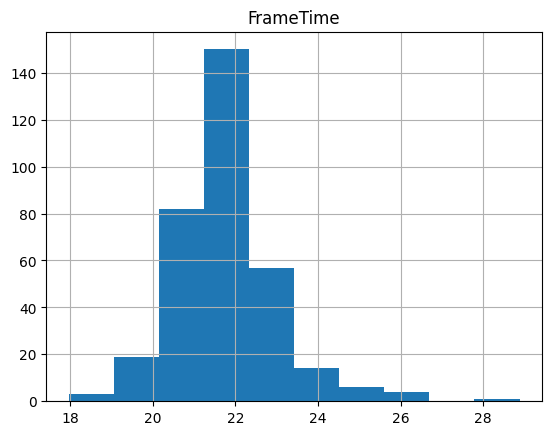

In [120]:
# display plot of shots recording
#In some tests like vfx it's more useful to display histogram of the frames then median
plt = shoots[['FrameTime']].hist()